# HW06: ML and Causal Inference (due November 9th)

**As a first part of THIS WEEK'S homework (HW06) you will have to provide feedback to two of your classmates' essays on Eduflow.** On Eduflow, you will be automatically assigned to the two essays you have to provide feedback to on Friday, in case you want to start ahead.

### For the coding part of the homework, you will have to solve only one of the three exercises.

## Exercise 1: Double Machine learning with XGboost

In this exercise you will investigate a research question similar to the one in HW02. Namely, what is the effect of being in a Union on wages? You will use the same data as in HW02 (description of the variables can be found [here](https://rdrr.io/rforge/sampleSelection/man/nlswork.html)). Although, here instead of just including controls, you will estimate the effect of union membership on wages using double machine learning and you will use XGboost as machine learning algorithm. The regression of reference is the following: 

$$ln\_wage_i = \beta_0 + \beta_1 union_i +\varepsilon_i$$

In [2]:
# Load Data (NLSY)
import pandas as pd
df = pd.read_stata('http://www.stata-press.com/data/r16/nlswork.dta')
df = df.dropna()

In [3]:
df.head()

,idcode,year,birth_yr,age,race,msp,nev_mar,grade,collgrad,not_smsa,...,south,ind_code,occ_code,union,wks_ue,ttl_exp,tenure,hours,wks_work,ln_wage
2,1,72,51,20.0,black,1.0,0.0,12.0,0,0.0,...,0.0,4.0,6.0,1.0,0.0,2.256410,0.916667,40.0,51.0,1.589977
5,1,77,51,25.0,black,0.0,0.0,12.0,0,0.0,...,0.0,12.0,8.0,0.0,0.0,3.775641,1.500000,32.0,52.0,1.778681
7,1,80,51,28.0,black,0.0,0.0,12.0,0,0.0,...,0.0,5.0,6.0,1.0,0.0,5.294872,1.833333,45.0,75.0,2.551715
9,1,85,51,33.0,black,0.0,0.0,12.0,0,0.0,...,0.0,5.0,6.0,1.0,0.0,7.160256,1.916667,42.0,97.0,2.614172
10,1,87,51,35.0,black,0.0,0.0,12.0,0,0.0,...,0.0,5.0,6.0,1.0,0.0,8.987180,3.916667,45.0,95.0,2.536374


In [4]:
import numpy as np
Y = df['ln_wage']
D = df['union']

In [5]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='Y ~ D', data=df)
print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     741.9
Date:                Tue, 08 Nov 2022   Prob (F-statistic):          4.56e-159
Time:                        10:01:32   Log-Likelihood:                -8266.7
No. Observations:               13452   AIC:                         1.654e+04
Df Residuals:                   13450   BIC:                         1.655e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6564      0.004    377.147      0.0

**What could be potential sources of bias (i.e. confounders)?**

In [6]:
pd.io.stata.StataReader('http://www.stata-press.com/data/r16/nlswork.dta').variable_labels()

{'idcode': 'NLS ID',
 'year': 'interview year',
 'birth_yr': 'birth year',
 'age': 'age in current year',
 'race': 'race',
 'msp': '1 if married, spouse present',
 'nev_mar': '1 if never married',
 'grade': 'current grade completed',
 'collgrad': '1 if college graduate',
 'not_smsa': '1 if not SMSA',
 'c_city': '1 if central city',
 'south': '1 if south',
 'ind_code': 'industry of employment',
 'occ_code': 'occupation',
 'union': '1 if union',
 'wks_ue': 'weeks unemployed last year',
 'ttl_exp': 'total work experience',
 'tenure': 'job tenure, in years',
 'hours': 'usual hours worked',
 'wks_work': 'weeks worked last year',
 'ln_wage': 'ln(wage/GNP deflator)'}

In [7]:
# fill in X with all predictors that are not colliders
X = df[['age', 'year', 'birth_yr', 'race', 'msp', 'grade', 'collgrad', 'c_city', 'south', 'wks_ue', 'tenure', 'hours', 'wks_work']]
X = pd.get_dummies(X, columns=['race'], drop_first=True)

In [8]:
from sklearn.model_selection import train_test_split
# split into sample A and sample B
X_A, X_B, Y_A, Y_B, D_A, D_B = train_test_split(X, Y, D, test_size=0.5, random_state=42)

# Within each sample, make a validation set for xgboost early stopping

X_A_train, X_A_val, Y_A_train, Y_A_val, D_A_train, D_A_val = train_test_split(X_A, Y_A, D_A, test_size=0.2, random_state=42)
X_B_train, X_B_val, Y_B_train, Y_B_val, D_B_train, D_B_val = train_test_split(X_B, Y_B, D_B, test_size=0.2, random_state=42)

In [9]:
# Step 1. In both samples, train an xgboost regressor model to predict log wages (outcome Y)
# use early stopping.
from xgboost import XGBRegressor
xgbr_a = XGBRegressor()
xgbr_b = XGBRegressor()

xgbr_a.fit(X_A_train, Y_A_train, eval_set=[(X_A_val, Y_A_val)], early_stopping_rounds=10, verbose=False)
xgbr_b.fit(X_B_train, Y_B_train, eval_set=[(X_B_val, Y_B_val)], early_stopping_rounds=10, verbose=False)


/Users/sverrirarnorsson/miniconda3/envs/brj/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [10]:
# Step 2. In both samples, train an xgboost classifier model to predict union status (treatment D)
# use early stopping.
from xgboost import XGBClassifier
xgbc_a = XGBClassifier()
xgbc_b = XGBClassifier()

xgbc_a.fit(X_A_train, D_A_train, eval_set=[(X_A_val, D_A_val)], early_stopping_rounds=10, verbose=False)
xgbc_b.fit(X_B_train, D_B_train, eval_set=[(X_B_val, D_B_val)], early_stopping_rounds=10, verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [11]:
# Step 3. Cross-fitting: Form predictions in other sample.

# predict wages in sample A using model trained in sample B:
Y_hat_A = xgbr_b.predict(X_A)

# vice versa:
Y_hat_B = xgbr_a.predict(X_B)
    
# predict union status in sample A using model trained in sample B:
D_hat_A = xgbc_b.predict(X_A)
    
# vice versa:
D_hat_B = xgbc_a.predict(X_B)
    

Recall that residuals for a variable $Z_i$ are computed as follows:

$$\tilde{Z}_i = Z_i - \hat{Z}_i$$

where $\hat{Z}_i$ is the predicted value of $Z_i$

In [12]:
# Compute residuals for wages and union status.

# residualized wages in samples A and B:
y_tilde_A =  Y_A - Y_hat_A
y_tilde_B =  Y_B - Y_hat_B

# residualized union status in samples A and B:
D_tilde_A =  D_A - D_hat_A
D_tilde_B =  D_B - D_hat_B

In [13]:
# Step 4. Run OLS regressions of the residualized variables and produce Double ML estimate
## use robust standard errors 
import statsmodels.api as sm

res_A = sm.OLS(y_tilde_A, exog=D_tilde_A).fit(cov_type='HC1')
beta_A = res_A.params
se_A = res_A.bse

res_B = sm.OLS(y_tilde_B, exog=D_tilde_B).fit(cov_type='HC1')
beta_B = res_B.params
se_B = res_B.bse

##Take the average of the two coefficient and standard errors and show the result
beta_avg = (beta_A + beta_B)/2
beta_sg = (se_A + se_B)/2
print("Average beta", beta_avg)
print("Standard error", beta_sg)

Average beta union    0.107705
dtype: float64
Standard error union    0.009299
dtype: float64


**Compare the estimates form this and the previous regression. How do these change?**

The magnitude of the estimate goes down by 50%, while the standard error is very similar.

**Interpret the coefficient from the double ml approach. Can it be interpreted as causal?**

Not neccesarily, there are still effects that can't be controlled for, such as indvidual fixed effects, so a different research design would be required.

## Exercise 2: Synthetic Control Method

In this exercise we will investigate the economic effects of conflict by focusing on the Basque Country. In particular, we will focus on terrorist conflicts in late 1960's in this area and use as comparison group all other regions of Spain that did not experience terrorism. The (raw) reference regression is the following:

$$gdpcap_r = \beta_0 + \beta_1 terrorism_r + \varepsilon_r$$

where $gdpcap_r$ is GDP per capita in region $r$ and $terrorism_r$ is a dummy equal to 1 if terrorist conflict happened in that region.

In [65]:
##note that to work correctly you will also have to downgrade scipy to version 1.4.1
!pip install scipy==1.4.1
!pip install SyntheticControlMethods

#restart the kernel after downrgading scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.9 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [547 lines of output]
      Ignoring numpy: markers 'python_version == "3.5" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.5" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
      Ignori

In [66]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_csv('data/HW06_data_scm.csv')
del df['Unnamed: 0']
del df['regionno']
df = df.loc[df["regionname"] != "Spain (Espana)"] 

df['terrorism'] = df['regionname']=='Basque Country (Pais Vasco)'
df['terrorism'] = df['terrorism'].astype('int')
df.head()

,regionname,year,gdpcap,sec.agriculture,sec.energy,sec.industry,sec.construction,sec.services.venta,sec.services.nonventa,school.illit,school.prim,school.med,school.high,school.post.high,popdens,invest,terrorism
43,Andalucia,1955,1.688732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
44,Andalucia,1956,1.758498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45,Andalucia,1957,1.827621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
46,Andalucia,1958,1.852756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47,Andalucia,1959,1.878035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


<AxesSubplot: xlabel='year', ylabel='gdpcap'>

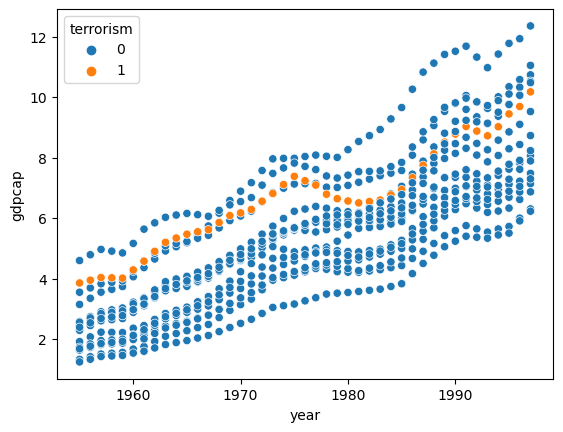

In [67]:
import seaborn as sns

##plot gdp per capita over time separately for basque country and other regions of spain
## (i.e., separately for terrorism == 1 or 0)
sns.scatterplot(data=df, x="year", y="gdpcap", hue="terrorism")

**Does the parallel trend assumption hold? If not, why do you think this is the case?**

In [68]:
## run a regression of terrorism on gdp per capita
ols = smf.ols("gdpcap ~ terrorism", df)
print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 gdpcap   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.33
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           0.000166
Time:                        12:38:24   Log-Likelihood:                -1627.0
No. Observations:                 731   AIC:                             3258.
Df Residuals:                     729   BIC:                             3267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3182      0.086     62.167      0.0

**What could be potential threats to a causal interpretation of this result?**

In [69]:
from SyntheticControlMethods import Synth, DiffSynth
# del df['terrorism']

##fit the synthetic control 
sc = Synth(df, "gdpcap", "regionname", "year", 1960, treated_unit="Basque Country (Pais Vasco)")

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp

/Users/sverrirarnorsson/miniconda3/envs/brj/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-con


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    0    f=     Infinity    |proj g|=          NaN



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-con


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-con


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-con


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    0    f=     Infinity    |proj g|=          NaN



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-con


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-con


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


AttributeError: 'NoneType' object has no attribute 'T'

In [ ]:
##visualize the plot 


**What can you conclude about the effect of conflict on GDP?**

In [8]:
## Show which spanish regions were used to create the synthetic control

## Exercise 3: Heterogenous Treatment Effects

In this exercise we will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group..

In this exercise we will focus on heterogenous treatment effects, rather than on isolating the casual effect of the treatment. In particular, we will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [9]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [10]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [11]:
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [12]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model

In [16]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [ ]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

df_treat = #TODO
df_control = #TODO

In [ ]:
##choose one of the three outcomes to analyze
## using xgboost regressor train two model to predict the outcome from the covariates
## the first model should be trained on the treated sample, while the second on the control
## use early stopping

from xgboost import XGBRegressor
xgbr_treat = XGBRegressor()
xgbr_control = XGBRegressor()

In [ ]:
##get predicted outcomes using the combined test sets for both models 

test_set = Xtreat_test.append(Xcontrol_test) 
y_hat_treat = ...
y_hat_control = ...

In [ ]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = ...

In [ ]:
##visualize and comment on the covariates of these individuals 